# Binary Classification using Deep Neural Network with Softmax

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import os
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('TensorFlow version', tf.__version__)

TensorFlow version 2.3.1


In [2]:
import cv2
import glob
import shutil
from collections import Counter

from keras.callbacks import Callback
from keras.backend import clear_session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
os.listdir()

['.ipynb_checkpoints',
 'Basic_CNN_BinaryClassification_TF2.ipynb',
 'Basic_CNN_Multi-Class_Classification_TF2.ipynb',
 'cheesecake_vs_friedrice',
 'dataset',
 'DNN_Sigmoid_BinaryClassification_TF2.ipynb',
 'DNN_Softmax_BinaryClassification_TF2.ipynb',
 'DNN_Softmax_Multi-Class_Classification_TF2.ipynb',
 'img',
 'MobileNet-v2_Multi-Class_Classification_TF2.ipynb',
 'README.MD']

In [4]:
os.getcwd()

'C:\\Users\\user\\Food_Classification'

In [5]:
base_dir = os.path.join(os.getcwd(), 'cheesecake_vs_friedrice')
base_dir

'C:\\Users\\user\\Food_Classification\\cheesecake_vs_friedrice'

In [6]:
classes = ['cheesecake', 'fried_rice']
classes

['cheesecake', 'fried_rice']

In [7]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.copy(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.copy(v, os.path.join(base_dir, 'val', cl))

cheesecake: 50 Images
fried_rice: 48 Images


In [8]:
# Set up path for training and validating path
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Augmentation to prevent overfitting

Since the dataset we have currently is only small amount of training data, therefore we need to perform augmentation to prevent overfitting. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

By using ImageDataGenerator class from tf.keras, we able to perform on the fly preprocessing transformations to the dataset during our training process.

In [9]:
batch_size = 10
IMG_SHAPE = 150

In [10]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size, directory=train_dir, shuffle=True,target_size=(IMG_SHAPE,IMG_SHAPE))

Found 78 images belonging to 2 classes.


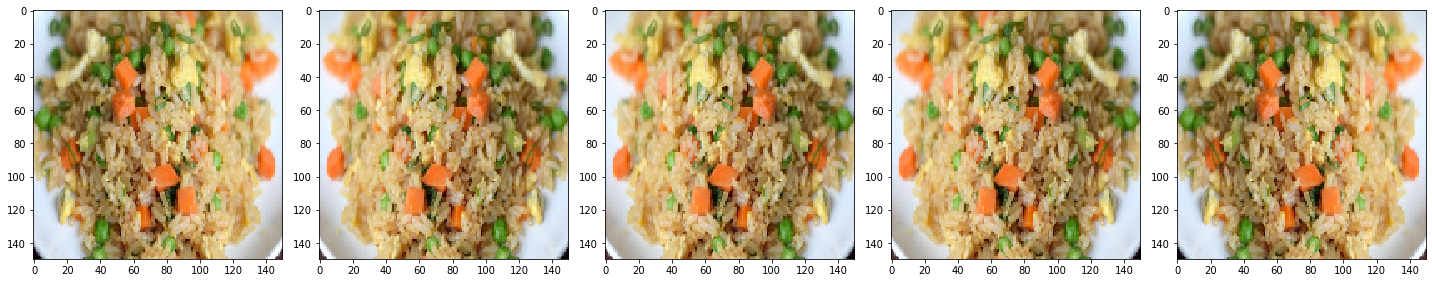

In [11]:
def plotImages(image_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip( image_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

augmented_images = [train_data_gen[6][0][0] for i in range(5)]
plotImages(augmented_images)

fried rice or cheese?

Found 78 images belonging to 2 classes.


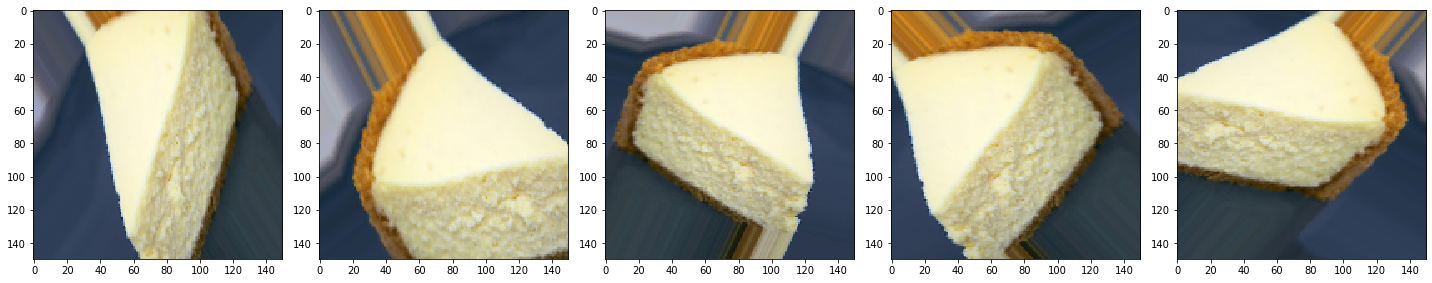

In [12]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [13]:
# validation data

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 20 images belonging to 2 classes.


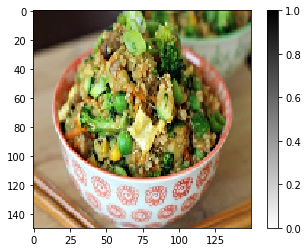

In [14]:
sample = val_data_gen[0][0][0]
plt.figure()
plt.imshow(sample, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Does this fried rice has any MSG? Uncle Roger might like this fried rice.

# Simple DNN model

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(2, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(4, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 2)       56        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 4)         76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 4)         0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 4

In [16]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/100
8/8 [==============================] - 2s 245ms/step - loss: 1.9497 - accuracy: 0.4615 - val_loss: 0.6585 - val_accuracy: 0.4500
Epoch 2/100
8/8 [==============================] - 2s 191ms/step - loss: 0.8211 - accuracy: 0.4615 - val_loss: 0.6931 - val_accuracy: 0.5500
Epoch 3/100
8/8 [==============================] - 2s 191ms/step - loss: 0.6931 - accuracy: 0.4744 - val_loss: 0.6931 - val_accuracy: 0.4500
Epoch 4/100
8/8 [==============================] - 2s 191ms/step - loss: 0.6931 - accuracy: 0.5128 - val_loss: 0.6931 - val_accuracy: 0.4000
Epoch 5/100
8/8 [==============================] - 2s 191ms/step - loss: 0.6931 - accuracy: 0.5128 - val_loss: 0.6931 - val_accuracy: 0.4000
Epoch 6/100
8/8 [==============================] - 2s 195ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4000
Epoch 7/100
8/8 [==============================] - 2s 190ms/step - loss: 0.6931 - accuracy: 0.5128 - val_loss: 0.6931 - val_accuracy: 0.4000
Epoch 8/100
8

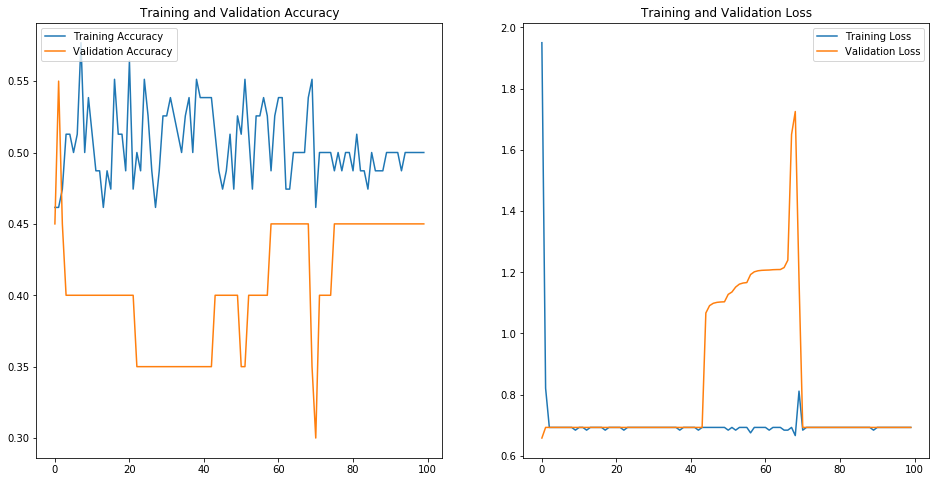

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test on unseen image from internet

To test the modol, I simply download few images of fried rice and cheesecake from internet randomly.

In [18]:
# read test data
import PIL
import PIL.Image
import pathlib

test_dir = pathlib.Path(test_dir)

In [19]:
image_count = len(list(test_dir.glob('*')))
print('Total test file: ',image_count)

Total test file:  4


In [20]:
def normalize(images):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images

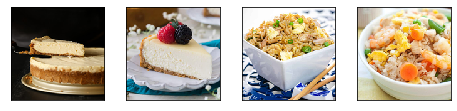

In [21]:
test_image = list(test_dir.glob('*'))

plt.figure(figsize=(10,10))
for i in range(len(test_image)):
    img = PIL.Image.open(test_image[i])
    img = img.resize((IMG_SHAPE,IMG_SHAPE), PIL.Image.ANTIALIAS)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
plt.show()

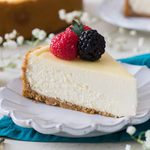

In [22]:
sample_img1 = PIL.Image.open(test_image[1]).resize((IMG_SHAPE,IMG_SHAPE), PIL.Image.ANTIALIAS)
sample_img1

In [23]:
test_array = []
y_pred = []
score_list = []

for test_url in test_image:
    test_img = tf.keras.preprocessing.image.load_img(test_url, target_size=(IMG_SHAPE,IMG_SHAPE))
    img_array = tf.keras.preprocessing.image.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    norm_img_array = normalize(img_array)
    test_array.append(norm_img_array)
    pred = model.predict(norm_img_array)[0]
    y_pred.append(np.argmax(pred))
    score = tf.nn.softmax(pred)
    score_list.append(score)

    print(
        "This food image is similar to {} with a {:.2f} percent confidence score."
        .format(classes[np.argmax(pred)], 100 * np.max(score))
    )
#     print('The actual file name is ', os.path.basename(os.path.normpath(test_url)))

This food image is similar to cheesecake with a 50.16 percent confidence score.
This food image is similar to cheesecake with a 50.20 percent confidence score.
This food image is similar to fried_rice with a 50.40 percent confidence score.
This food image is similar to fried_rice with a 50.10 percent confidence score.


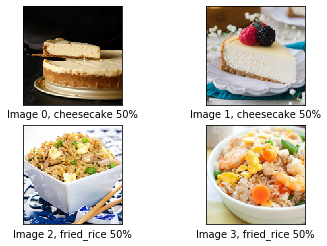

In [24]:
for i in range(len(test_image)):
    predictions_array, img = y_pred[i], test_image[i]

    img = PIL.Image.open(test_image[i])
    img = img.resize((IMG_SHAPE,IMG_SHAPE), PIL.Image.ANTIALIAS)
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = predictions_array


    plt.xlabel("Image {}, {} {:2.0f}%".format(i, classes[predicted_label],100*np.max(score_list[i])))

### Manually Calculate F1 Score

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.


*Notes*
Based on documentation from sklearn, the 'average' parameter is required for multiclass/multilabel targets. If None, the scores for each class are returned.

'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [25]:
from sklearn.metrics import f1_score

# By default, the 0 is represent cheesecake, while 1 represents fried rice
y_true = [0, 0, 1, 1]

micro_f1_score = f1_score(y_true, y_pred, average='micro')
print('F1 score micro is ', micro_f1_score)
macro_f1_score = f1_score(y_true, y_pred, average='macro')
print('F1 score macro is ', macro_f1_score)
weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
print('F1 score weighted is ', weighted_f1_score)

F1 score micro is  1.0
F1 score macro is  1.0
F1 score weighted is  1.0


In [26]:
print('Avg acc      :', np.mean(acc))
print('Avg val_acc  :', np.mean(val_acc))
print('Avg loss     :', np.mean(loss))
print('Avg val_loss :', np.mean(val_loss))

Avg acc      : 0.5056410324573517
Avg val_acc  : 0.4074999964237213
Avg loss     : 0.7065787011384964
Avg val_loss : 0.8258150732517242
